### I had constant issues with fiona 
- at first: (specifically _GEOSArea symbol not found); this was likely something messed up with my GDAL path due to installations of QGIS and gdal conflicting... [src]
- after that: i tried to uninstall fiona, etc. go that route again b/c it had worked before... but in between doing this i updated my OS to High Sierra
- then I had problems with pip in general, potentially an SSL cert issue between pip/LibreSSL (the installed version of OpenSSL with High Sierra)
- for the life of me i couldn't get anything to work
- final solution was to switch to homebrew and use virtualenvs, then creating a custom kernel from the virtualenv
- note: this virtual env was created with access to site packages. im not sure why regular python2 kernels wont work (it is likely due to wrong setup in kernel.json, i.e. it doesnt point to correct python env [http://jupyter-client.readthedocs.io/en/stable/kernels.html])


In [2]:
import fiona
import osmnx as ox

In [3]:
import shapely
import math
import pyproj
import sys

import numpy as np
import matplotlib.pyplot as plt, pandas as pd, geopandas as gpd

from matplotlib import pyplot
from functools import partial
from shapely import geometry
from shapely.ops import transform
from descartes import PolygonPatch
from matplotlib.patches import Arc
from shapely.geometry import Point, Polygon, MultiPolygon
%matplotlib inline

### CUSTOM CLASSES
sys.path.append('../../../alg')
import distance_buffer as db
import border_generators as bg


In [4]:
reload(bg)

<module 'border_generators' from '../../../alg/border_generators.pyc'>

In [5]:
reload(db)

<module 'distance_buffer' from '../../../alg/distance_buffer.pyc'>

## Get the place and show it

In [6]:
gdf, placegeom = bg.getplace('Walnut Creek, California, USA')

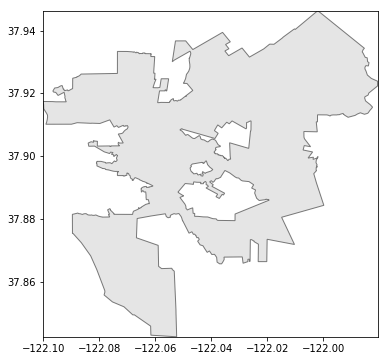

In [7]:
# plot the city
west, south, east, north = gdf.unary_union.bounds
fig, ax = plt.subplots(figsize=(6,6))
for polygon in placegeom:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=2)
    ax.add_patch(patch)
    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [8]:
proj = partial(pyproj.transform, pyproj.Proj(init='epsg:4326'),pyproj.Proj(init='epsg:3857'))
transgeom = transform(proj, placegeom)

## Try to find the relative inflection points of the polygon

In [9]:
def find_infl_pts(coordlist):
    
    l = len(coordlist)
    inflpts = []
    rad = 100
    for i in range(0, l-1):
        a = coordlist[i]
        b = coordlist[i+1]
        if i==l-2:           # final iteration, loop back around for final point
            c = coordlist[0]
        else:
            c = coordlist[i+2]
        ang =numpy.rad2deg(ang_between(a,b,c))
        #ang = numpy.rad2deg(ang_bw_vectorst(a, b, c, b))
        #print str(ang)+"  from "+str(from1)+"  to "+str(to1)+"   to2 "+str(to2)
        l1 = db.eucdist(a[0],a[1],b[0],b[1])
        l2 = db.eucdist(b[0],b[1],c[0],c[1])
        #print ang
        if ang <= 125.0 and ang >= -125.0 and (l1[0]>=rad or l2[0]>=rad):
            inflpts.append(b)
            print ang
        #else:
            #print f1, t1, t2
            #print ang
            #print i
            
    return inflpts
    

## Find correct way to measure interior angles

In [10]:
extcoords = transgeom[0].exterior.coords
first30 = []
for i in range(0, 100):
    first30.append(extcoords[i])


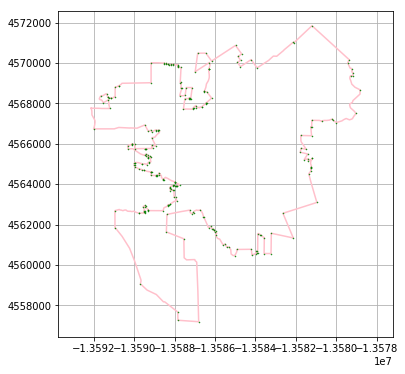

In [65]:
a = extcoords[15]
b= extcoords[16]
c=extcoords[17]
fig2, ax2=plt.subplots(figsize=(6,6))
ax2.plot(zip(*extcoords)[0], zip(*extcoords)[1], color='pink')

#for arc in arcs:
#    ax2.add_patch(arc)
    

#ax2.scatter(zip(*inflpts)[0],zip(*inflpts)[1] )
#ax2.scatter([a[0],b[0],c[0]],[a[1],b[1],c[1]], color='green')
ax2.scatter(zip(*markdegs)[0], zip(*markdegs)[1], s=0.25, color='green', zorder=4)
plt.axis('equal')
ax2.grid(True, which='both')
plt.savefig('WalnutCreekCA_anglearcsall_marked', dpi=192 * 10)

plt.show()

In [64]:
arcs = []
degs = []
markdegs = []
for i in range(0,len(extcoords)-1):
    
    a = extcoords[i]
    b = extcoords[i+1]
    c = extcoords[i+2]
    l1 = db.eucdist(a[0],a[1],b[0],b[1])[0]
    l2 = db.eucdist(b[0],b[1],c[0],c[1])[0]
    ml = min(l1,l2)
    

    ang, thetas =angle_between(a,b,c)
   
    
    
    arcs.append(Arc(b, ml, ml, theta1=thetas[0], theta2=thetas[1]))
    if thetas[0] < 0.0:
        thetas[0]+=360
    if thetas[1] < 0.0:
        thetas[1]+=360
    tdeg = abs(thetas[1]-thetas[0])
    print str(thetas[1]) + "  -  "+str(thetas[0])+"  =  "+str(tdeg)
    if tdeg <= 130.0 or tdeg >= 230.0:
        markdegs.append(b)
    degs.append(tdeg)
    

103.89192522919508
-77.74916884251388
181.64109407170895
103.89192522919508  -  282.2508311574861  =  178.35890592829105
102.25083115748612
-88.59670763393413
190.84753879142025
102.25083115748612  -  271.4032923660659  =  169.15246120857978
91.40329236606587
-60.79366490627254
152.1969572723384
91.40329236606587  -  299.2063350937275  =  207.80304272766162
119.20633509372746
-66.02515315611744
185.23148824984492
119.20633509372746  -  293.9748468438826  =  174.7685117501551
113.97484684388256
-87.3468708922054
201.32171773608798
113.97484684388256  -  272.6531291077946  =  158.67828226391202
92.65312910779461
-97.04115303619146
189.69428214398607
92.65312910779461  -  262.9588469638085  =  170.30571785601393
82.95884696380854
-101.75579288775305
184.71463985156157
82.95884696380854  -  258.24420711224695  =  175.28536014843843
78.24420711224697
-109.21479998796485
187.4590071002118
78.24420711224697  -  250.78520001203515  =  172.5409928997882
70.78520001203516
0.07851118740799484
70.

-179.4206383952077
89.9941831058837
90.58517849890859
180.5793616047923  -  89.9941831058837  =  90.58517849890859
-90.00581689411631
-19.956441190637626
289.9506242965213
269.9941831058837  -  340.04355880936237  =  70.04937570347869
160.0435588093624
-23.057913610407805
183.1014724197702
160.0435588093624  -  336.9420863895922  =  176.8985275802298
156.94208638959222
-49.336550563822954
206.27863695341517
156.94208638959222  -  310.6634494361771  =  153.72136304658486
130.66344943617705
-82.03059408940595
212.694043525583
130.66344943617705  -  277.96940591059405  =  147.305956474417
97.96940591059406
-43.3165321153409
141.28593802593497
97.96940591059406  -  316.6834678846591  =  218.71406197406503
136.6834678846591
-88.37251906566483
225.05598695032393
136.6834678846591  -  271.62748093433515  =  134.94401304967604
91.62748093433518
-70.20922469856735
161.83670563290252
91.62748093433518  -  289.79077530143263  =  198.16329436709745
109.79077530143266
-48.40981429609598
158.2005895

-169.757142803145
9.715619211116055
180.52723798573894
190.242857196855  -  9.715619211116055  =  180.52723798573894
-170.28438078888396
9.761567181936304
179.95405202917973
189.71561921111604  -  9.761567181936304  =  179.95405202917973
-170.2384328180637
-73.93801005898221
263.69957724091853
189.7615671819363  -  286.06198994101777  =  96.30042275908147
106.06198994101779
-36.252783867606084
142.31477380862387
106.06198994101779  -  323.74721613239393  =  217.68522619137616
143.74721613239393
16.29637423371547
127.45084189867846
143.74721613239393  -  16.29637423371547  =  127.45084189867846
-163.70362576628452
105.14269595904862
91.15367827466685
196.29637423371548  -  105.14269595904862  =  91.15367827466686
-74.85730404095138
53.63287246770273
231.50982349134588
285.14269595904864  -  53.63287246770273  =  231.5098234913459
-126.36712753229726
25.09518525351662
208.53768721418612
233.63287246770273  -  25.09518525351662  =  208.5376872141861
-154.9048147464834
-15.39610017076386
2

-72.97600374430174
114.5659313593702
172.45806489632807
287.02399625569825  -  114.5659313593702  =  172.45806489632804
-65.4340686406298
90.12659351182926
204.43933784754094
294.5659313593702  -  90.12659351182926  =  204.43933784754097
-89.87340648817074
61.69379464055782
208.43279887127144
270.12659351182924  -  61.69379464055782  =  208.43279887127142
-118.30620535944219
-9.064479806819547
250.75827444737735
241.69379464055783  -  350.9355201931805  =  109.24172555262265
170.93552019318045
80.13778718856203
90.79773300461842
170.93552019318045  -  80.13778718856203  =  90.79773300461842
-99.86221281143797
140.81751253651404
119.320274652048
260.137787188562  -  140.81751253651404  =  119.32027465204797
-39.18248746348597
94.44620918803753
226.3713033484765
320.817512536514  -  94.44620918803753  =  226.3713033484765
-85.55379081196247
164.19328676208124
110.25292242595629
274.4462091880375  -  164.19328676208124  =  110.25292242595629
-15.806713237918768
114.5294624024208
229.66382

8.965872301293135  -  241.90504294994219  =  232.93917064864905
61.9050429499422
-85.94669949474516
147.85174244468737
61.9050429499422  -  274.0533005052548  =  212.14825755531263
94.05330050525485
-41.743686458065504
135.79698696332036
94.05330050525485  -  318.2563135419345  =  224.20301303667964
138.2563135419345
-2.1920946723217214
140.44840821425623
138.2563135419345  -  357.80790532767827  =  219.55159178574377
177.8079053276783
-32.855440321541046
210.66334564921934
177.8079053276783  -  327.14455967845896  =  149.33665435078066
147.14455967845896
-56.74434180247451
203.88890148093347
147.14455967845896  -  303.25565819752546  =  156.1110985190665
123.25565819752549
30.601155127087807
92.65450307043768
123.25565819752549  -  30.601155127087807  =  92.65450307043768
-149.39884487291218
-79.44399074365353
290.04514587074135
210.60115512708782  -  280.55600925634644  =  69.95485412925862
100.55600925634647
-94.48512461778265
195.04113387412912
100.55600925634647  -  265.5148753822

IndexError: index out of range

In [49]:
print len(markdegs)

281


In [36]:
print degs[1:20]

[190.84753879142025, 152.1969572723384, 185.23148824984492, 201.32171773608798, 189.69428214398607, 184.71463985156157, 187.4590071002118, 70.70668882462716, -196.5917998227332, -160.35199393691312, 179.85007334174, 146.85419954789523, -147.53674743737034, 155.37876843299134, -95.27268112366326, 87.97458416075551, -100.8781070328952, 103.8263211037141, -90.1802432488247]


In [26]:

tryang, thetas = angle_between(a,b,c)
print thetas


-157.5239889382019
-62.25130781453864
264.72731887633677
[-62.25130781453864, -157.5239889382019]


In [ ]:
360-95.2726811237

In [27]:
print vecs

NameError: name 'vecs' is not defined

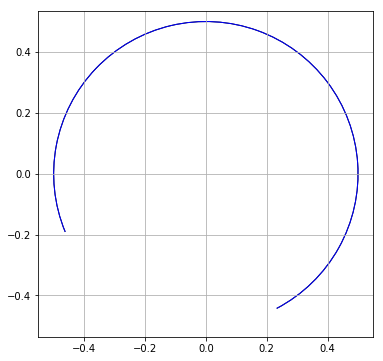

In [32]:
fig4, ax4=plt.subplots(figsize=(6,6))


arctry1 = Arc([0,0], 1.0, 1.0, theta1=-62.25130781453864, theta2=-157.5239889382019)#theta1=-62.25130781453864, theta2=t)#-62.25130781453864)#theta1 = -19.2,theta2 = 180.0+19.2)
#arctry2 = Arc([0,0], 1.0, 1.0, theta1=-62.25130781453864, theta2=-62.25130781453864+np.rad2deg(tryang), color='pink')#theta1=-62.25130781453864, theta2=t)#-62.25130781453864)#theta1 = -19.2,theta2 = 180.0+19.2)
arctry3 = Arc([0,0], 1.0, 1.0, theta1=-62.25130781453864, theta2=-62.25130781453864-95.2726811237, color='blue')
#ax4.plot([vecs[0][0], 0], [vecs[0][1], 0], color='red')
#ax4.plot([vecs[1][0], 0], [vecs[1][1], 0], color='red')
#ax4.plot([b[0], c[0]], [b[1], c[1]], color='blue')
#ax4.scatter(b[0],b[1], color='green')
#ax4.scatter(c[0],c[1], color='pink')
ax4.add_patch(arctry1)
#ax4.add_patch(arctry2)
ax4.add_patch(arctry3)
plt.axis('equal')
ax4.grid(True, which='both')
plt.show()

In [ ]:
np.rad2deg(tryang) % 180

In [38]:
def angle_between(a, b, c):
    v1_u = unit_vector(np.array(a)-np.array(b))
    v2_u = unit_vector(np.array(c)-np.array(b))
    ang1 = np.arctan2(*v1_u[::-1])
    deg1= np.rad2deg(ang1)
    print deg1
    ang2 = np.arctan2(*v2_u[::-1])
    deg2 =np.rad2deg(ang2)
    print deg2
    #vs=[v1_u,v2_u]
    thetas = [deg2, deg1]
    
    ang = np.array((ang1 - ang2) % (2 * math.pi))
    deg = (deg1-deg2) % 360
    print deg
    #print ang
    return ang, thetas#vs

In [19]:
def unit_vector(vector):
    return (vector / np.linalg.norm(vector))

In [20]:
v1_u

NameError: name 'v1_u' is not defined